<a href="https://colab.research.google.com/github/BroBay24/CelebA_ResNet18_FaceAttr-Clasifier/blob/main/CelebA_ResNet18_SmileClassification_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CelebA Face Attribute Classification with ResNet-18
Notebook lengkap untuk mendeteksi atribut *Smiling* pada dataset CelebA menggunakan PyTorch dan ResNet-18 yang siap dijalankan di Google Colab.

## Alur Notebook
1. Import & setup lingkungan eksekusi.
2. Load metadata atribut & partition dari CelebA.
3. Preprocessing & augmentasi data.
4. Konstruksi *dataset* dan *dataloader*.
5. Definisi model ResNet-18 dan komponen training.
6. Loop training lengkap dengan scheduler dan penyimpanan model terbaik.
7. Evaluasi di validation & test set (akurasi, confusion matrix, visualisasi).
8. Plot metrik training dan ringkasan hasil.

In [ ]:
import os
import copy
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set seed untuk hasil reprodusibel di CPU/GPU
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")
if device.type == "cuda":
    torch.backends.cudnn.benchmark = True

Menggunakan device: cpu


## Konfigurasi Path & Parameter
Sesuaikan `DATASET_ROOT` dengan lokasi folder `datasetFIX` di Google Colab. Struktur yang diharapkan:

```
datasetFIX/
├── img_align_celeba/
│   └── img_align_celeba/000001.jpg, ...
├── list_attr_celeba.csv
└── list_eval_partition.csv
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/archive.zip

/content/drive/MyDrive/archive.zip


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/archive.zip'
extract_path = '/content/datasetFIX'

# Buat folder tujuan kalau belum ada
os.makedirs(extract_path, exist_ok=True)

# Ekstrak zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset berhasil diekstrak ke:", extract_path)


✅ Dataset berhasil diekstrak ke: /content/datasetFIX


In [ ]:
# Ganti path ini jika dataset berada di lokasi berbeda
DATASET_ROOT = Path("/content/datasetFIX/img_align_celeba")
IMAGES_DIRNAME = "/content/datasetFIX/img_align_celeba/img_align_celeba"
ATTR_FILENAME = "/content/datasetFIX/list_attr_celeba.csv"
PARTITION_FILENAME = "/content/datasetFIX/list_eval_partition.csv"
BEST_MODEL_PATH = Path("resnet18_celeba_smiling_best.pth")

BATCH_SIZE = 32
NUM_EPOCHS = 3
LEARNING_RATE = 1e-4
STEP_SIZE = 5  # Digunakan apabila memilih StepLR
GAMMA = 0.1
USE_COSINE_SCHEDULER = False  # Set True bila ingin mencoba CosineAnnealingLR

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]


def resolve_image_dir(root_dir: Path) -> Path:
    """Memastikan path folder gambar valid meski terdapat sub-folder berulang."""
    if not root_dir.exists():
        raise FileNotFoundError(f"Folder gambar tidak ditemukan: {root_dir}")
    # Jika langsung berisi file .jpg
    if any(root_dir.glob('*.jpg')):
        return root_dir
    nested = root_dir / "img_align_celeba"
    if nested.exists():
        return resolve_image_dir(nested)
    raise FileNotFoundError("Struktur folder img_align_celeba tidak sesuai. Periksa kembali.")

attr_path = DATASET_ROOT / ATTR_FILENAME
partition_path = DATASET_ROOT / PARTITION_FILENAME
image_root = resolve_image_dir(DATASET_ROOT / IMAGES_DIRNAME)

print(f"Metadata atribut: {attr_path}")
print(f"Metadata partition: {partition_path}")
print(f"Folder gambar: {image_root}")
sample_image = next(image_root.glob('*.jpg'), None)
if sample_image:
    print(f"Contoh file gambar: {sample_image.name}")

Metadata atribut: /content/datasetFIX/list_attr_celeba.csv
Metadata partition: /content/datasetFIX/list_eval_partition.csv
Folder gambar: /content/datasetFIX/img_align_celeba/img_align_celeba
Contoh file gambar: 082513.jpg


## Load Metadata Atribut & Partition
- `Smiling` diubah dari {-1, 1} menjadi {0, 1}.
- `list_eval_partition` dipakai untuk membagi data menjadi *train/val/test*.

In [ ]:
attrs_df = pd.read_csv(attr_path)
attrs_df = attrs_df[["image_id", "Smiling"]].copy()
attrs_df["Smiling"] = attrs_df["Smiling"].replace({-1: 0, 1: 1}).astype(np.float32)

partitions_df = pd.read_csv(partition_path)
partitions_df = partitions_df.rename(columns={"partition": "split"})
split_map = {0: "train", 1: "val", 2: "test"}
partitions_df["split"] = partitions_df["split"].map(split_map)

merged_df = attrs_df.merge(partitions_df, on="image_id")
split_dfs = {split: df[["image_id", "Smiling"]].reset_index(drop=True)
             for split, df in merged_df.groupby("split") }

for split, df in split_dfs.items():
    print(f"{split:>5}: {len(df):,} sampel | rasio smiling = {df['Smiling'].mean():.3f}")

 test: 19,962 sampel | rasio smiling = 0.500
train: 162,770 sampel | rasio smiling = 0.480
  val: 19,867 sampel | rasio smiling = 0.483


## Transformasi & Dataset
Resize ke 64×64, normalisasi, dan augmentasi *RandomHorizontalFlip* untuk train set.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

eval_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

class CelebADataset(Dataset):
    """Dataset sederhana untuk atribut CelebA yang mengembalikan image tensor dan label 0/1."""
    def __init__(self, dataframe: pd.DataFrame, image_dir: Path, transform=None):
        super().__init__()
        self.records = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        if len(self.records) == 0:
            raise ValueError("Dataframe kosong; pastikan metadata termuat dengan benar")

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        row = self.records.iloc[idx]
        image_path = self.image_dir / row["image_id"]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(row["Smiling"], dtype=torch.float32)
        return {"image": image, "label": label, "image_id": row["image_id"]}

    def get_image_path(self, idx):
        return self.image_dir / self.records.iloc[idx]["image_id"]

    def get_label(self, idx):
        return int(self.records.iloc[idx]["Smiling"])

## DataLoader
Membuat *DataLoader* untuk train, validation, dan test tanpa shuffle pada val/test.

In [ ]:
num_workers = min(4, os.cpu_count() or 1)
pin_memory = device.type == "cuda"

train_dataset = CelebADataset(split_dfs["train"], image_root, transform=train_transform)
val_dataset = CelebADataset(split_dfs["val"], image_root, transform=eval_transform)
test_dataset = CelebADataset(split_dfs["test"], image_root, transform=eval_transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

print(f"Batch train: {len(train_loader)} | Batch val: {len(val_loader)} | Batch test: {len(test_loader)}")

Batch train: 5087 | Batch val: 621 | Batch test: 624


## Model ResNet-18 & Komponen Training
Menggunakan bobot pra-latih ImageNet, mengganti layer terakhir menjadi 1 neuron untuk klasifikasi biner.

In [ ]:
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
if USE_COSINE_SCHEDULER:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
else:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}
best_record = {"epoch": 0, "val_acc": 0.0}

/tmp/ipython-input-304500475.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")


## Fungsi Training & Evaluasi

In [ ]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_probs, all_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            images = batch["image"].to(device, non_blocking=True)
            labels = batch["label"].to(device, non_blocking=True).unsqueeze(1)
            logits = model(images)
            loss = criterion(logits, labels)
            running_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(logits).detach().cpu()
            all_probs.append(probs)
            all_labels.append(labels.detach().cpu())
    probs = torch.cat(all_probs, dim=0)
    labels = torch.cat(all_labels, dim=0)
    preds = (probs >= 0.5).float()
    accuracy = (preds == labels).float().mean().item()
    avg_loss = running_loss / len(data_loader.dataset)
    return avg_loss, accuracy, probs.numpy().ravel(), labels.numpy().ravel(), preds.numpy().ravel()

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, num_epochs, device, best_path):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)
        for batch in progress_bar:
            images = batch["image"].to(device, non_blocking=True)
            labels = batch["label"].to(device, non_blocking=True).unsqueeze(1)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
                logits = model(images)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size
            preds = (torch.sigmoid(logits) >= 0.5).float()
            running_corrects += (preds == labels).sum().item()
            total_samples += batch_size

            progress_bar.set_postfix({
                "loss": running_loss / total_samples,
                "acc": running_corrects / total_samples
            })

        train_loss = running_loss / total_samples
        train_acc = running_corrects / total_samples
        val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lr"].append(optimizer.param_groups[0]["lr"])

        if val_acc > best_record["val_acc"]:
            best_record["val_acc"] = val_acc
            best_record["epoch"] = epoch + 1
            torch.save(model.state_dict(), best_path)
            print(f"[Epoch {epoch + 1}] Model terbaik tersimpan dengan val_acc={val_acc:.4f}")

        scheduler.step()
        print(f"Epoch {epoch + 1:02d} | train_loss={train_loss:.4f} | train_acc={train_acc:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")

    return model

## Jalankan Training

In [ ]:
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, NUM_EPOCHS, device, BEST_MODEL_PATH)
print(f"Model terbaik tersimpan di: {BEST_MODEL_PATH.resolve()}")
if BEST_MODEL_PATH.exists():
    state_dict = torch.load(BEST_MODEL_PATH, map_location=device)
    model.load_state_dict(state_dict)
    print(f"Memuat bobot terbaik dari epoch {best_record['epoch']} dengan val_acc={best_record['val_acc']:.4f}")

Epoch 1/3:   0%|          | 0/5087 [00:00<?, ?it/s]

/tmp/ipython-input-166681236.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


[Epoch 1] Model terbaik tersimpan dengan val_acc=0.9199
Epoch 01 | train_loss=0.2245 | train_acc=0.9049 | val_loss=0.1920 | val_acc=0.9199


Epoch 2/3:   0%|          | 0/5087 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a14c3bb7a60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


[Epoch 2] Model terbaik tersimpan dengan val_acc=0.9250
Epoch 02 | train_loss=0.1856 | train_acc=0.9229 | val_loss=0.1768 | val_acc=0.9250


Epoch 3/3:   0%|          | 0/5087 [00:00<?, ?it/s]

[Epoch 3] Model terbaik tersimpan dengan val_acc=0.9256
Epoch 03 | train_loss=0.1748 | train_acc=0.9261 | val_loss=0.1745 | val_acc=0.9256
Model terbaik tersimpan di: /content/resnet18_celeba_smiling_best.pth
Memuat bobot terbaik dari epoch 3 dengan val_acc=0.9256


## Evaluasi: Validation & Test
Hitung akurasi, tampilkan confusion matrix, dan contoh prediksi.

Validation | loss=0.1745 | acc=0.9256
Test        | loss=0.1801 | acc=0.9233


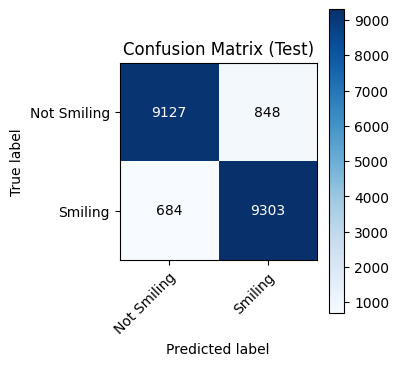

Classification Report:
              precision    recall  f1-score   support

 Not Smiling       0.93      0.91      0.92      9975
     Smiling       0.92      0.93      0.92      9987

    accuracy                           0.92     19962
   macro avg       0.92      0.92      0.92     19962
weighted avg       0.92      0.92      0.92     19962



In [ ]:
val_loss, val_acc, val_probs, val_labels, val_preds = evaluate(model, val_loader, criterion, device)
print(f"Validation | loss={val_loss:.4f} | acc={val_acc:.4f}")

test_loss, test_acc, test_probs, test_labels, test_preds = evaluate(model, test_loader, criterion, device)
print(f"Test        | loss={test_loss:.4f} | acc={test_acc:.4f}")

cm = confusion_matrix(test_labels, test_preds)
classes = ["Not Smiling", "Smiling"]

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, ylabel="True label", xlabel="Predicted label", title="Confusion Matrix (Test)")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.tight_layout()
plt.show()

print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=classes))

## Visualisasi Contoh Prediksi

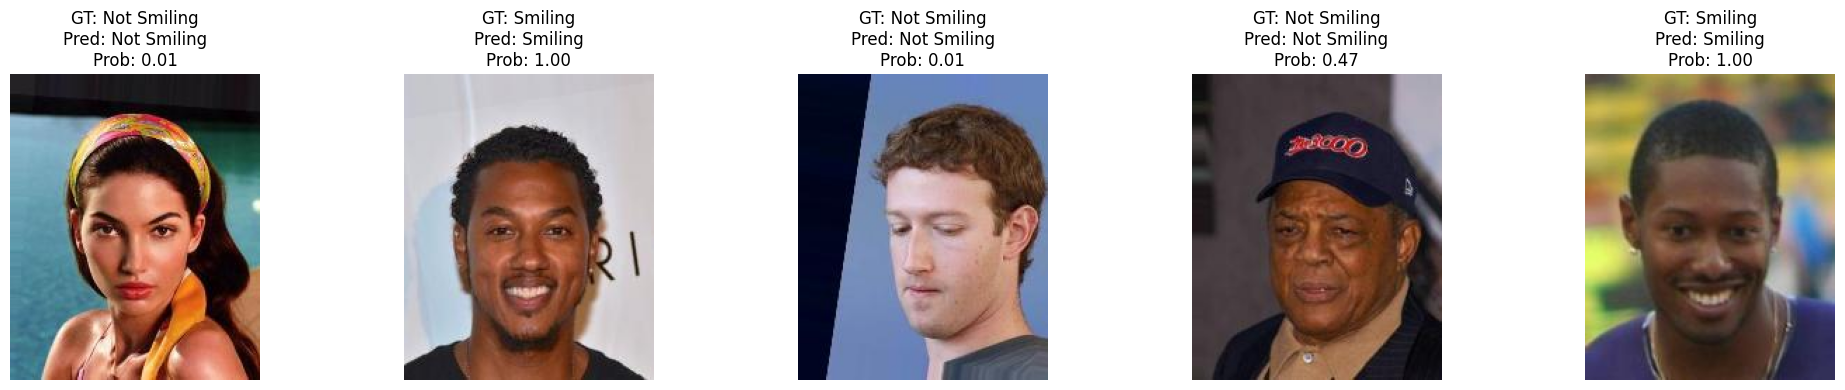

In [ ]:
num_examples = 5
indices = np.random.choice(len(test_dataset), size=num_examples, replace=False)
flatten_probs = test_probs.flatten()
labels_text = {0: "Not Smiling", 1: "Smiling"}

fig, axes = plt.subplots(1, num_examples, figsize=(4 * num_examples, 4))
if num_examples == 1:
    axes = [axes]
for ax, idx in zip(axes, indices):
    image_path = test_dataset.get_image_path(idx)
    image = Image.open(image_path).convert("RGB")
    ax.imshow(image)
    gt = test_dataset.get_label(idx)
    pred = int(test_preds[idx])
    prob = float(flatten_probs[idx])
    ax.set_title((f"GT: {labels_text[gt]}\n"
                  f"Pred: {labels_text[pred]}\n"
                  f"Prob: {prob:.2f}"))
    ax.axis("off")
plt.tight_layout()
plt.show()

## Plot Metrik Training

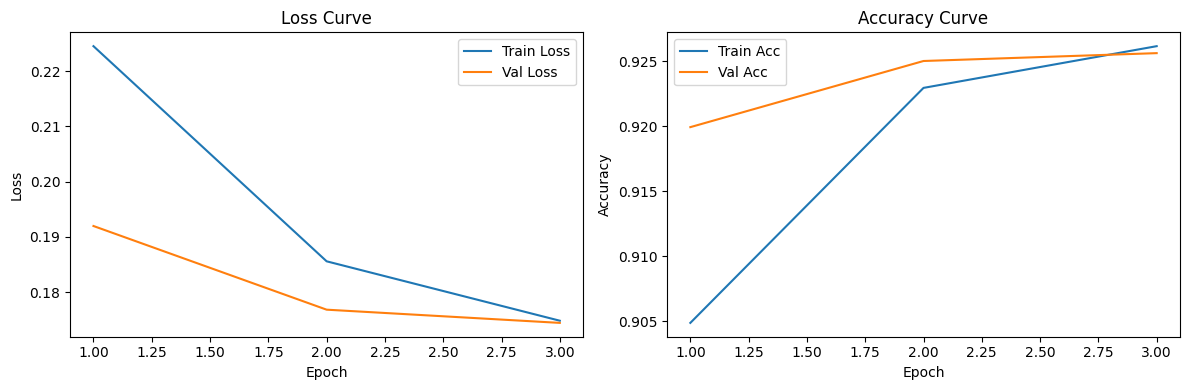

In [ ]:
epochs = np.arange(1, len(history["train_loss"]) + 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(epochs, history["train_loss"], label="Train Loss")
axes[0].plot(epochs, history["val_loss"], label="Val Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss Curve")
axes[0].legend()

axes[1].plot(epochs, history["train_acc"], label="Train Acc")
axes[1].plot(epochs, history["val_acc"], label="Val Acc")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Accuracy Curve")
axes[1].legend()

plt.tight_layout()
plt.show()

## Kesimpulan & Langkah Lanjutan
- Model ResNet-18 pra-latih mampu membedakan wajah tersenyum vs tidak setelah fine-tuning pada atribut `Smiling`.
- Confusion matrix membantu melihat distribusi error (misal masih ada false positive/negative).
- Untuk akurasi lebih tinggi, dapat dicoba: jumlah epoch lebih banyak, *class balancing*, augmentasi tambahan, atau *unfreezing* layer awal secara bertahap.